In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import seaborn as sns
import matplotlib.pyplot as plt     

In [2]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = os.listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

def give_indxs(col):
    t = []
    for ind, value in zip(data.index,data[col].values):
        try:
            int(value)
        except:
            t.append(ind)
    return t

features_df = pd.read_csv("../../UNSW/dataset/info_files/NUSW-NB15_features.csv",encoding='cp1252')
features = list(features_df['Name'])
len(features)

filenames = find_csv_filenames("../../UNSW/dataset/")
data = pd.DataFrame(columns=features)
temp = []
for name in filenames:
    base_path = "../../UNSW/dataset/"
    temp_df = pd.read_csv(f"{base_path}/{name}",names=features)
    temp.append(temp_df)
data = pd.concat(temp,ignore_index=True)
data.reset_index(inplace=True,drop=True)
print(data.shape)

data['attack_cat'].fillna('benign',inplace=True)
data['attack_cat'].isna().sum()

data['ct_flw_http_mthd'].fillna(data['ct_flw_http_mthd'].mean(),inplace=True)
data['is_ftp_login'].fillna(data['is_ftp_login'].mean(),inplace=True)
data['ct_flw_http_mthd'].isna().sum(), data['is_ftp_login'].isna().sum()

data['service'].replace({'-':'not_used'},inplace=True)
cols = ['dstip','srcip','proto','state','service']
for col in cols:
    dict_items = {}
    j=0
    for k,i in data[col].value_counts().items():
        dict_items[k] = j
        j += 1
    data[col] = data[col].replace(dict_items)

cols = ['sport','dsport','ct_ftp_cmd']
for col in cols:
    n_ind = give_indxs(col)
    if len(n_ind) > 1000000:
        del data[col]
    elif len(n_ind) > 0:
        data.drop(index=n_ind,inplace=True)
        data[col] = pd.to_numeric(data[col])
        
data['attack_cat'] = data['attack_cat'].apply(lambda x:x.strip()).replace({"Backdoors":"Backdoor"})

j = 0
label_dict = {}
for k,i in data.iloc[:,-2].value_counts().items():
    label_dict[k] = j
    j += 1
label_dict

def label_mapper(r,info=label_dict):
    return info[r]  
data['attack_cat'] = data['attack_cat'].apply(label_mapper)

cols = list(data.columns)[0:-1]
df = data[cols]
df.rename({'attack_cat': 'Label'}, axis='columns',inplace=True)
df.columns

C:\Users\axylo\AppData\Local\Temp\ipykernel_19972\1299612026.py:23: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(f"{base_path}/{name}",names=features)
C:\Users\axylo\AppData\Local\Temp\ipykernel_19972\1299612026.py:23: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(f"{base_path}/{name}",names=features)


(2540047, 49)


C:\Users\axylo\AppData\Local\Temp\ipykernel_19972\1299612026.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename({'attack_cat': 'Label'}, axis='columns',inplace=True)


Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload',
       'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime',
       'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Label'],
      dtype='object')

In [3]:
label_dict

{'benign': 0,
 'Generic': 1,
 'Exploits': 2,
 'Fuzzers': 3,
 'DoS': 4,
 'Reconnaissance': 5,
 'Analysis': 6,
 'Backdoor': 7,
 'Shellcode': 8,
 'Worms': 9}

In [4]:
df.Label.value_counts()

0    2218456
1     215481
2      44525
3      24246
4      16353
5      13987
6       2677
7       2329
8       1511
9        174
Name: Label, dtype: int64

In [5]:
LEARNING_RATE = 0.001
EPOCHS = 5
BATCH_SIZE = 64
BUFFER_SIZE = int(BATCH_SIZE * 10)
NON_ZERO_DAY_CLASSES = [0,1,3,4,7]

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(),inplace=True)

df_ = df[df.Label.isin(NON_ZERO_DAY_CLASSES)]

X = df_.iloc[:,:-1]
y = df_.iloc[:,-1]
y[y!=0] = 1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=128)

zero = df[~df.Label.isin(NON_ZERO_DAY_CLASSES)]
X_zero = zero.iloc[:,:-1]
y_zero = np.ones(X_zero.shape[0])

C:\Users\axylo\AppData\Local\Temp\ipykernel_19972\2511474187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\axylo\AppData\Local\Temp\ipykernel_19972\2511474187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(),inplace=True)
C:\Users\axylo\AppData\Local\Temp\ipykernel_19972\2511474187.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [7]:
ls = len(y_train[y_train == 1])
sz = int(ls + ls * 0.1)

In [8]:
print(np.unique(y_train,return_counts=True))
X_train_d = pd.concat([X_train[y_train==0].sample(n=sz),X_train[y_train==1]])
y_train_d = np.concatenate([np.zeros(sz),np.ones(ls)])
print(np.unique(y_train_d,return_counts=True))

(array([0, 1], dtype=int64), array([1774969,  206523], dtype=int64))
(array([0., 1.]), array([227175, 206523], dtype=int64))


In [9]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train_d)
X_valid_sc = sc.transform(X_valid)
X_zero_sc = sc.transform(X_zero)

In [10]:
tem = X_valid_sc[y_valid==0]
X_test_sc = np.concatenate((tem, X_zero_sc), axis=0)
y_test = np.concatenate((np.zeros(tem.shape[0]),np.ones(X_zero_sc.shape[0])))

In [11]:
X_train_sc, y_train_d = shuffle(X_train_sc, y_train_d)
X_valid_sc, y_valid = shuffle(X_valid_sc, y_valid.values)
X_test_sc, y_test = shuffle(X_test_sc, y_test)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sc,y_train_d)) 
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_sc, y_valid))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_sc, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
class AccentuatedLayer(tf.keras.layers.Layer):
    def __init__(self, emb_dim, kernels, name=None):
        super(AccentuatedLayer, self).__init__(name=name)
        self.emb_dim = emb_dim
        self.projected_emb = tf.keras.layers.Dense(emb_dim, activation='tanh', trainable=True)
        self.pattern_kernels = tf.Variable(tf.random_normal_initializer()(shape=[kernels,emb_dim], dtype=tf.float32)
                                           ,trainable=True)
    
    def compute_cosine_sim(self, a, b):
        normalize_a = tf.nn.l2_normalize(a,1)        
        normalize_b = tf.nn.l2_normalize(b,1)
        sim = tf.matmul(normalize_a, normalize_b, transpose_b=True)
        return sim
    
    def call(self, inputs, hidden_smx=None):
        embs = self.projected_emb(inputs)
        similarity = self.compute_cosine_sim(embs,self.pattern_kernels)
        smx = tf.math.softmax(similarity)
        if hidden_smx is None:
            cell_outs = tf.einsum('ij,ik->ikj', embs, smx)
            return cell_outs, smx
        else:
            sidx = tf.argsort(hidden_smx)
            weighted_scores = tf.gather(tf.cumsum(tf.sort(hidden_smx,axis=1),axis=1),sidx,axis=1, batch_dims = 1)
            sofsm = tf.einsum("ij,ijk->ijk",weighted_scores,smx)
            cell_outs = tf.reduce_sum(tf.einsum("ijk,ijl->ijlk",embs,sofsm),axis=1)
            return cell_outs, tf.reduce_sum(smx,axis=1)

In [14]:
inp_layer = tf.keras.layers.Input(shape=(46,))

ac_vec, hid= AccentuatedLayer(32,kernels=16,name=f"AccentLayer1")(inp_layer)
ac_vec, hid = AccentuatedLayer(16,kernels=8,name=f"AccentLayer2")(ac_vec, hid)
dp = tf.keras.layers.Dropout(0.2)(ac_vec)

flt = tf.keras.layers.Flatten()(dp)
outl = tf.keras.layers.Dense(1,activation='sigmoid')(flt)

model = tf.keras.Model(inputs=inp_layer,outputs=outl)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
AccentLayer1 (AccentuatedLayer) ((None, 16, 32), (No 2016        input_1[0][0]                    
__________________________________________________________________________________________________
AccentLayer2 (AccentuatedLayer) ((None, 8, 16), (Non 656         AccentLayer1[0][0]               
                                                                 AccentLayer1[0][1]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 8, 16)        0           AccentLayer2[0][0]           

In [18]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),metrics=['acc'])

In [19]:
history = model.fit(train_dataset,epochs=EPOCHS, validation_data=valid_dataset)

Epoch 1/5
6777/6777 [==============================] - 119s 17ms/step - loss: 0.0373 - acc: 0.9891 - val_loss: 0.0259 - val_acc: 0.9873
Epoch 2/5
6777/6777 [==============================] - 108s 16ms/step - loss: 0.0231 - acc: 0.9925 - val_loss: 0.0287 - val_acc: 0.9873
Epoch 3/5
6777/6777 [==============================] - 97s 14ms/step - loss: 0.0224 - acc: 0.9926 - val_loss: 0.0244 - val_acc: 0.9875
Epoch 4/5
6777/6777 [==============================] - 97s 14ms/step - loss: 0.0219 - acc: 0.9927 - val_loss: 0.0282 - val_acc: 0.9875
Epoch 5/5
6777/6777 [==============================] - 101s 15ms/step - loss: 0.0214 - acc: 0.9928 - val_loss: 0.0254 - val_acc: 0.9876


In [20]:
y_valid_pred = np.array(model.predict(valid_dataset)>0.5,dtype=np.int32)

In [21]:
print(classification_report(y_valid,y_valid_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    443487
           1       0.89      1.00      0.94     51886

    accuracy                           0.99    495373
   macro avg       0.95      0.99      0.97    495373
weighted avg       0.99      0.99      0.99    495373



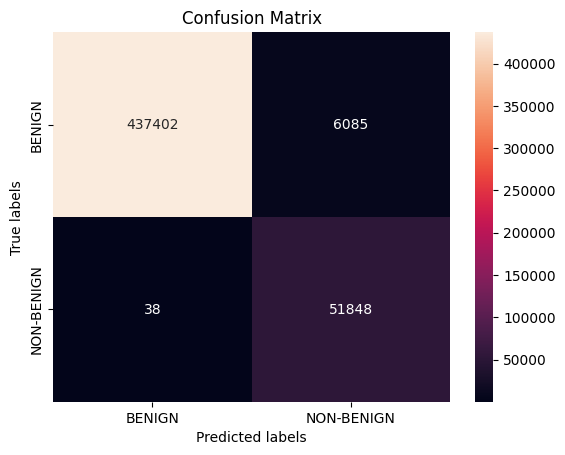

In [22]:
cm = confusion_matrix(y_valid,y_valid_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

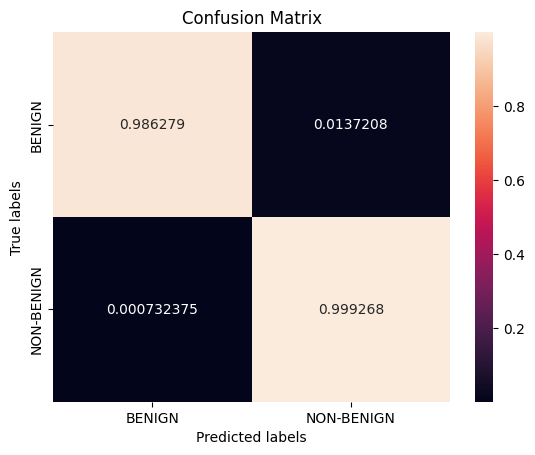

In [23]:
ax= plt.subplot()
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

In [24]:
y_test_pred_prob = model.predict(test_dataset)

In [48]:
y_test_pred = np.array(y_test_pred_prob>0.5,dtype=np.int32)

In [49]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    443487
         1.0       0.91      0.98      0.94     62874

    accuracy                           0.99    506361
   macro avg       0.95      0.98      0.97    506361
weighted avg       0.99      0.99      0.99    506361



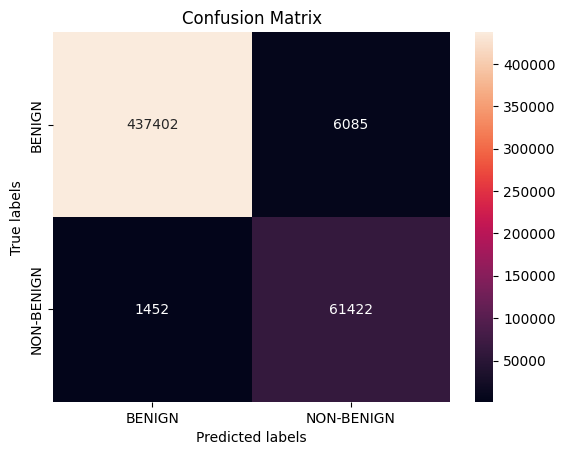

In [50]:
cm = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

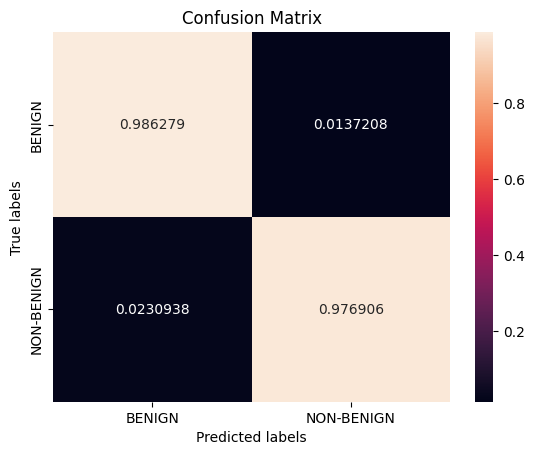

In [51]:
ax= plt.subplot()
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

In [52]:
accuracy_score(y_test,y_test_pred),f1_score(y_test,y_test_pred)

(0.9851153623600554, 0.9421924973730834)